In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

In [3]:
# REMARK: There are no spherical TOKAMAKs in these analyses.  

DB2P8 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"DB5.csv")

DB2P8 = DB2P8[DB5.columns]

# How was this chosen? Is this a form of removing outliers or noise to the new regression?
# Why not simply use the whole DB5?
new_ids = pd.read_csv(path+"new_point_ids.csv")
                  
R = pd.read_csv(path+"R.csv") #DB5[DB5.id.isin(new_ids.id.values)] #reintroduce dataset

DB2 = DB2P8[["TAUTH"] + coeffs].apply(np.abs).apply(np.log)
DB2["id"] = DB2P8["id"]

reg_data = pd.read_csv(path+"data.csv")

In [4]:
def get_regression_np(_R):
    data = pd.concat([DB2, _R],
                     axis=0, 
                     ignore_index=True
                    )
    Y_ = data[["TAUTH"]].to_numpy()
    # Adding a column for the intercept
    _df = data[coeffs]; _df.insert(
        loc = 0, 
        column = "intercept", 
        value = np.ones(len(_df))
    )
    X_ = _df.to_numpy()
    n_, p_ = X_.shape
    model = sm.OLS(Y_,X_)
    regression = model.fit()
    return data, regression, (n_,p_)

# Getting regression of DB2P8 only. 
regression_DB2 = get_regression_np(R[R.id.isin([0])])[1]
#regression_DB2.summary()

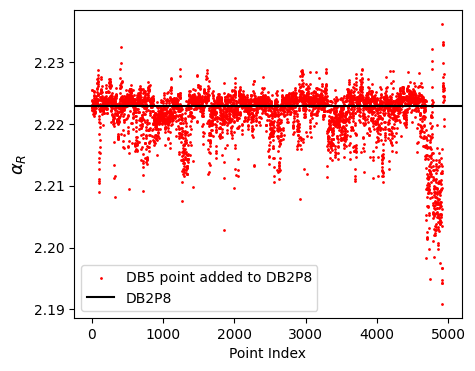

In [5]:
plt.figure(figsize=(5,4))
plt.scatter(reg_data.index, reg_data.αR, s=1, c="r", label="DB5 point added to DB2P8")
plt.axhline(regression_DB2.params[5], c="k", label="DB2P8")
plt.xlabel("Point Index")
plt.ylabel("$\\alpha_R$", fontsize=13)
plt.legend();

In [6]:
# Leave the ones above baseline out -- because we are interested in the reduction of value
pts_minimize = reg_data[reg_data.αR < regression_DB2.params[5] ]
pts_minimize = pts_minimize.sort_values("αR", ascending=True)


# Ordering dataset ids from smallest to greatest alpha-R 

dict_ordered_vals = dict(zip( 
    pts_minimize.id_added.values, 
    list(range(len(pts_minimize)))  
) )

DB5_decreas_pts = R[R.id.isin(pts_minimize.id_added)]
DB5_decreas_pts.insert(0, "ordered", DB5_decreas_pts.id.map(dict_ordered_vals))

DB5_decreas_pts = DB5_decreas_pts.sort_values("ordered")
DB5_decreas_pts = DB5_decreas_pts.set_index("ordered")

In [7]:
reg_coeff_per_pts = np.zeros(len(pts_minimize))
for i in range(1, len(pts_minimize) + 1):
    # Adding one point at a time to DB2P8 from DB5 od decreasing subset in an ordered manner.
    R_ = (DB5_decreas_pts.iloc[:i][["TAUTH"] + coeffs])
    # Storing regression coefficient for alpha_R only
    reg_coeff_per_pts[i-1] = get_regression_np(R_)[1].params[5]
    
DB5_decreas_pts["αR_per_pts_in_DB2"] = reg_coeff_per_pts

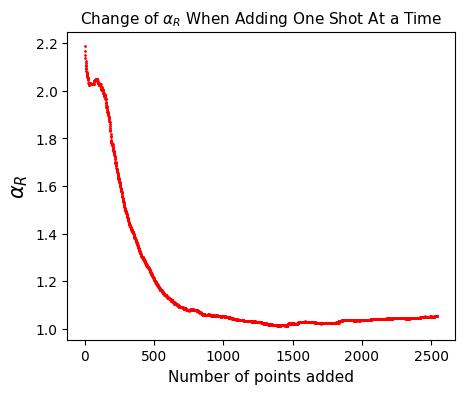

In [8]:
#%matplotlib notebook

plt.figure(figsize=(5,4))
plt.scatter(DB5_decreas_pts.index + 1, DB5_decreas_pts["αR_per_pts_in_DB2"], s=1, c = "r")
plt.xlabel("Number of points added", fontsize=11)
plt.ylabel("$\\alpha_R$", fontsize=15)
plt.title("Change of $\\alpha_R$ When Adding One Shot At a Time", fontsize=11);

In [9]:
# Labeling shots that decreased or increased the overall regression when added
df = DB5_decreas_pts[["αR_per_pts_in_DB2"]]
df.insert(0, "prev_val", [regression_DB2.params[5]] + list(df["αR_per_pts_in_DB2"].iloc[:-1].values))
df.insert(0, "difference", df["αR_per_pts_in_DB2"] - df["prev_val"])
DB5_decreas_pts.insert(0, "decreased", df.difference.apply(lambda x: 1 if x<=0 else 0))
DB5_decreas_pts.insert(0, "weights", DB5_decreas_pts.decreased.values/len(DB5_decreas_pts) + 1 )

In [10]:
num_samples = 500

"""max_amount = len( DB5_decreas_pts ) + 1
SAMPLES = np.zeros((num_samples, max_amount - 1))

for i in range(num_samples):
    for j in range(1, max_amount):
        R_sampled = DB5_decreas_pts.sample(n=j, weights='weights', random_state=71*(i + 3))
        SAMPLES[i,j-1] = get_regression_np(R_sampled)[1].params[5]""";

In [11]:
"""for s in range(num_samples):
    plt.plot(range(1, max_amount), SAMPLES[s,], label=f'seed {71*(s + 3)}')
plt.title("Sampling from Decreased Dataset")
plt.xlabel("Number of Random Samples in Decreasing DB5")
plt.ylabel("$\\alpha_R$", fontsize=15)
#plt.savefig("decreased_dataset_500.jpg", format="jpg", dpi=800);""";

In [12]:
"""for s in range(num_samples):
    print( min(SAMPLES[s,]), np.argmin(SAMPLES[s,]))""";

In [13]:
#big_dataset = pd.DataFrame(SAMPLES, columns=[f"subset_{i+1}" for i in range(SAMPLES.shape[-1])])
#big_dataset["seed"] = [71*(i + 3) for i in range(num_samples)]
#big_dataset.to_csv(path+"decreased_dataset_random_sampling_500.csv", index=False)

In [14]:
max_amount_ = len( DB5_decreas_pts[DB5_decreas_pts.decreased.isin([1])] ) + 1
SAMPLES_ = np.zeros((num_samples, max_amount_ - 1))

for i in range(num_samples):
    for j in range(1, max_amount_):
        R_sampled = DB5_decreas_pts.sample(n=j, weights='decreased', random_state=71*(i + 3))
        SAMPLES_[i,j-1] = get_regression_np(R_sampled)[1].params[5]

In [27]:
#decreased_dataset = pd.DataFrame(SAMPLES_[:num_samples,:], columns=[f"subset_{i+1}" for i in range(SAMPLES_.shape[-1])])
#decreased_dataset["seed"] = [71*(i + 3) for i in range(num_samples)]
#decreased_dataset.to_csv(path+"decreased_dataset_random_sampling_500_decreasing_points.csv", index=False)
#decreased_dataset

(600.0, 1494.435)

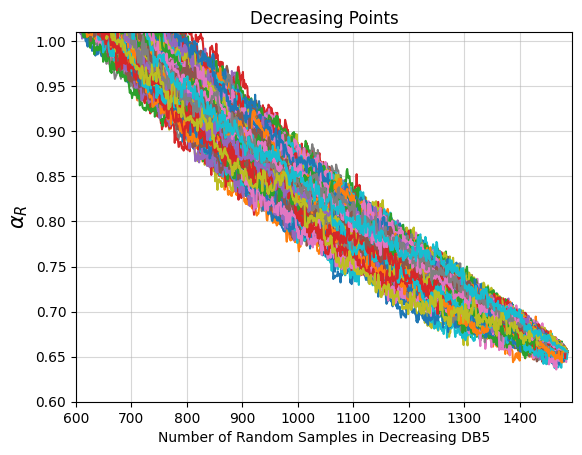

In [53]:
for s in range(num_samples):
    plt.plot(range(1,max_amount_), SAMPLES_[s,], label=f'seed {71*(s + 3)}')
plt.title("Decreasing Points")
plt.xlabel("Number of Random Samples in Decreasing DB5")
plt.ylabel("$\\alpha_R$", fontsize=15)

plt.grid(alpha=0.5)
ax = plt.gca()
ax.set_ylim([0.6, 1.01])
ax.set_xlim([600, max_amount_*1.005])

#plt.savefig("decreased_dataset_500_decreased_pts_zoom.jpg", format="jpg", dpi=800);

In [ ]:
"""for s in range(num_samples):
    print( min(SAMPLES_[s,]), np.argmin(SAMPLES_[s,]))"""

In [43]:
decreased_dataset.describe()

subset_1    subset_2    subset_3    subset_4    subset_5    subset_6  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     2.217562    2.212190    2.206843    2.201648    2.196932    2.191802   
std      0.004980    0.006883    0.008601    0.009444    0.010079    0.010753   
min      2.193381    2.176146    2.172289    2.167856    2.158397    2.155309   
25%      2.215712    2.209540    2.203109    2.196408    2.191226    2.186431   
50%      2.219504    2.213934    2.208879    2.203500    2.198522    2.193094   
75%      2.220925    2.217313    2.212834    2.208874    2.204061    2.199519   
max      2.222090    2.221007    2.219952    2.216315    2.214914    2.211651   

         subset_7    subset_8    subset_9   subset_10   subset_11   subset_12  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     2.187071    2.181669    2.176786    2.171908    2.167027    2.162221   
std      0.011449    0.012399    0.013258    0.013897    0.014337    0.015024   
min      2.147838    2.137208    2.130685    2.129143    2.124838    2.111614   
25%      2.181280    2.174140    2.168153    2.164166    2.158515    2.153154   
50%      2.188091    2.183312    2.177617    2.173041    2.167689    2.162795   
75%      2.195209    2.190834    2.187044    2.183097    2.177926    2.173416   
max      2.207831    2.204236    2.201747    2.198739    2.194732    2.192190   

        subset_13   subset_14   subset_15   subset_16   subset_17   subset_18  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     2.157485    2.152584    2.147996    2.143513    2.139036    2.134385   
std      0.015285    0.015596    0.015992    0.016252    0.016561    0.016933   
min      2.107150    2.105962    2.100930    2.099954    2.095946    2.086310   
25%      2.148133    2.142550    2.137048    2.132444    2.127225    2.123579   
50%      2.157897    2.154100    2.149397    2.144971    2.140176    2.135471   
75%      2.169573    2.164447    2.159364    2.155603    2.150714    2.146081   
max      2.188406    2.187537    2.186433    2.185218    2.178651    2.173504   

        subset_19   subset_20   subset_21   subset_22   subset_23   subset_24  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     2.129797    2.125177    2.120210    2.115654    2.111415    2.107089   
std      0.017221    0.017712    0.017928    0.018013    0.018230    0.018433   
min      2.084570    2.081740    2.071349    2.067105    2.065875    2.053565   
25%      2.117986    2.113880    2.108408    2.103543    2.099238    2.094742   
50%      2.130754    2.125815    2.121351    2.116071    2.111969    2.107472   
75%      2.141416    2.137677    2.132832    2.127731    2.124034    2.119726   
max      2.170089    2.167034    2.163852    2.158304    2.153748    2.152775   

        subset_25   subset_26   subset_27   subset_28   subset_29   subset_30  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     2.102873    2.098242    2.094055    2.089881    2.085624    2.081461   
std      0.018635    0.019117    0.019310    0.019366    0.019574    0.019833   
min      2.050250    2.043673    2.037476    2.036462    2.031826    2.022501   
25%      2.090498    2.085161    2.081474    2.075875    2.072316    2.067401   
50%      2.102000    2.097769    2.094024    2.089609    2.084878    2.080517   
75%      2.115843    2.111827    2.108177    2.104516    2.100470    2.096174   
max      2.149420    2.148037    2.143072    2.139728    2.137758    2.135878   

        subset_31   subset_32   subset_33   subset_34   subset_35   subset_36  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     2.077491    2.073166    2.068841    2.064663    2.060413    2.056236   
std      0.020168    0.020276    0.020694    0.020622    0.020985    0.021192   
min      2.021074    2.014830    2.

In [44]:
# Found Subset with Minimum alpha_R
decreased_dataset.describe().loc["min"].keys()[np.argmin(decreased_dataset.describe().loc["min"])]

'subset_1466'

In [46]:
# Minimum alpha_R generated by random sampling
min(decreased_dataset.describe().loc["min"]) 

0.6357571952782819

In [48]:
# Seed that generated the minimum alpha_R with 1466 sampling
indx = decreased_dataset[decreased_dataset["subset_1466"]
                         .isin([ min(decreased_dataset.describe().loc["min"])  ])].index
decreased_dataset["seed"][indx]

356    25489
Name: seed, dtype: int64

In [ ]:
#random_sampling.to_csv(path+"random_sampling_min_subset.csv")

In [49]:
R_ = DB5_decreas_pts.sample(n=1466, weights='decreased', random_state=25489)
R_

,weights,decreased,ind,id,PHASE,TOK,IP,BT,NEL,PLTH,RGEO,KAREA,EPS,MEFF,TAUTH,DATE,SHOT,TIME,Q95,ZEFF,AMIN,VOL,POHM,PNBI,DWDIA,DWMHD,PICRH,PECRH,PL,PFLOSS,TAV,LCOULOMB,QCYL5,TAUBOHM,RHOSTAR,BETASTAR,NUSTAR,OMEGACYCL,αR_per_pts_in_DB2
ordered,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1695,1.000393,1,15741,NZONFW,HGELM,AUGW,-0.003305,0.898534,2.138418,1.629241,0.481191,0.463734,-1.123645,0.693147,-2.354510,20120316,27562,3.25,1.559827,NaN,0.526000,14.050000,663800.000000,4.987000e+06,NaN,6896.0,0.000000e+00,0.0,5.640000e+06,324300.000000,962.431344,14.881857,1.225132,0.116586,-5.320472,-0.039952,-1.031238,1.228000,1.023012
421,1.000393,1,22633,1O4PQQ,HGELMH,JETILW,0.903691,0.981271,2.116035,2.940501,1.068311,0.438789,-1.160782,0.682232,-1.621661,20160122,89702,52.30,1.203099,1.540350,0.911675,74.051597,865513.636364,1.491320e+07,-21922.9,28231.1,3.280494e+06,0.0,1.908113e+07,155800.443381,1440.536379,15.296356,0.895160,0.266436,-5.756996,0.175500,-1.519912,1.348562,1.294118
1775,1.000393,1,15657,ONMHZ9,HGELM,AUGW,-0.003105,0.867521,2.077565,1.574846,0.481809,0.461845,-1.128072,0.693147,-2.388034,20110324,26627,3.25,1.522572,NaN,0.524000,13.930000,395800.000000,4.803000e+06,NaN,-105200.0,0.000000e+00,0.0,5.350000e+06,519900.000000,943.512775,14.892431,1.184443,0.109300,-5.295576,-0.058630,-1.085105,1.190500,1.025262
935,1.000393,1,22914,NQGQCG,HGELMH,JETILW,0.604648,1.018583,1.423139,2.635243,1.067260,0.409142,-1.140909,0.655946,-1.834922,20161005,91902,51.45,1.464903,1.456052,0.928997,74.567758,359568.869565,9.550819e+06,10074.0,-13640.5,4.396471e+06,0.0,1.429678e+07,350083.463434,1703.093291,15.810235,1.233260,0.229401,-5.742557,-0.424589,-2.207385,1.437114,1.053879
938,1.000393,1,15146,52CYZO,HGELM,AUG,0.001000,0.911479,1.548626,1.947338,0.506215,0.494696,-1.253396,0.693147,-2.378171,20030314,17220,6.05,1.354288,1.672000,0.473700,12.040000,153500.000000,4.932000e+06,NaN,-53530.0,2.314000e+06,0.0,7.450000e+06,368700.000000,2716.878030,16.214529,1.025555,0.115344,-4.709802,0.382142,-3.590743,1.244000,1.054648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,1.000393,1,14680,9RZQQA,HGELM,AUG,0.001000,0.741461,1.712536,1.913977,0.508623,0.494086,-1.257706,0.693147,-2.256656,20020110,15025,2.60,1.184484,2.502000,0.472800,12.020000,148800.000000,7.263000e+06,NaN,-101700.0,0.000000e+00,0.0,7.510000e+06,531200.000000,2522.813190,16.058465,0.849928,0.109883,-4.574937,0.811980,-3.455041,1.049500,1.076872
816,1.000393,1,20785,9ZUHRI,HGELM,JET,0.941958,1.014143,1.759753,2.421257,1.064366,0.468104,-1.121360,0.691646,-1.145075,19980116,44030,61.63,1.264692,2.108000,0.944600,81.540000,718600.000000,1.073000e+07,4436.0,NaN,0.000000e+00,0.0,1.144000e+07,176200.000000,1790.698661,15.692088,0.986112,0.439298,-5.711843,-0.028936,-2.257959,1.380571,1.074750
1188,1.000393,1,16276,3VR4J8,HGELM,AUGW,-0.515671,0.611395,1.959108,1.976855,0.484892,0.366724,-1.147316,0.693147,-3.395613,20171026,34946,3.45,1.624917,NaN,0.515600,12.290000,190000.000000,7.264000e+06,NaN,9360.0,0.000000e+00,0.0,7.440000e+06,195500.000000,605.618469,14.508299,1.312025,0.030889,-5.244969,-0.108195,-0.183442,0.921500,1.033112


In [50]:
get_regression_np(R_)[1].params[5]

0.6357571952782819

In [ ]:
#R_[["id"]].to_csv(path+"R_ids_alpha_0.6357.csv", index=False)

In [58]:
dds_desc = decreased_dataset.describe().T
dds_desc[dds_desc["min"] < 1]

,count,mean,std,min,25%,50%,75%,max
subset_618,500.0,1.075430,2.516722e-02,0.999819,1.059427,1.075858,1.093212,1.140729
subset_620,500.0,1.074244,2.512192e-02,0.996038,1.057820,1.074158,1.091503,1.142468
subset_621,500.0,1.073449,2.469672e-02,0.993856,1.057383,1.073463,1.089176,1.145893
subset_622,500.0,1.072418,2.475338e-02,0.999299,1.056548,1.071739,1.089867,1.146693
subset_623,500.0,1.071569,2.481324e-02,0.996279,1.056329,1.070519,1.087602,1.138063
...,...,...,...,...,...,...,...,...
subset_1482,500.0,0.656978,1.462005e-03,0.646097,0.656374,0.656991,0.657698,0.660510
subset_1483,500.0,0.656670,1.395315e-03,0.645037,0.656133,0.656698,0.657309,0.660247
subset_1484,500.0,0.656404,1.067983e-03,0.643961,0.655973,0.656271,0.656852,0.659166
subset_1485,500.0,0.656077,7.899273e-04,0.647636,0.655836,0.655980,0.656287,0.658435
